In [206]:
# Donwload libraries
!pip install scikit-learn
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install scikit-multilearn
!pip install kagglehub
!git lfs install
!git lfs pull
!pip install plotly
!pip install nba_api

Updated Git hooks.
Git LFS initialized.


# Importing libraries and packages

In [216]:
#  git lfs track "*.csv" to track all csv files

import os
import glob
import kagglehub
import sqlite3
#Data Wrangling

import numpy as np
import pandas as pd

#Trees
from sklearn import tree
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Preprocessing Packages
from sklearn.model_selection import train_test_split

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Model tuning
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Aditonal Data Sources
from nba_api.stats.endpoints import TeamInfoCommon
from nba_api.stats.static import teams

%matplotlib inline

Loading Data Sets

In [ ]:
# set up respective path to the data
project_root = os.path.abspath(os.path.join(".."))
print(project_root)
data_path = os.path.join(project_root, "raw-data/")
print(data_path)

# concatenate all seasons of data in a single df
df = pd.DataFrame()
files = glob.glob(os.path.join(data_path, '*_Shots.csv'))
# for file in os.listdir(data_path):
#     file_path=os.path.join(data_path,file)
#     data=pd.read_csv(file_path)
#     df=pd.concat([df,data],ignore_index=True)
#     print(file)
df = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
df.head()

# Data Dictionary

**Self-Explanatory**: **TEAM_NAME**, **PLAYER_NAME**, **POSITION_GROUP**, **POSITION**, **HOME_TEAM**, **AWAY_TEAM**

- **SEASON_1** & **SEASON_2**: Season indicator variables  
- **TEAM_ID**: NBA's unique ID variable of that specific team in their API  
- **PLAYER_ID**: NBA's unique ID variable of that specific player in their API  
- **GAME_DATE**: Date of the game (M-D-Y // Month-Date-Year)  
- **GAME_ID**: NBA's unique ID variable of that specific game in their API  
- **EVENT_TYPE**: Character variable denoting a shot outcome (Made Shot // Missed Shot)  
- **SHOT_MADE**: True/False variable denoting a shot outcome (True // False)  
- **ACTION_TYPE**: Description of shot type (layup, dunk, jump shot, etc.)  
- **SHOT_TYPE**: Type of shot (2PT or 3PT)  
- **BASIC_ZONE**: Name of the court zone the shot took place in  
  - Restricted Area, In the Paint (non-RA), Midrange, Left Corner 3, Right Corner 3, Above the Break, Backcourt  
- **ZONE_NAME**: Name of the side of court the shot took place in  
  - left, left side center, center, right side center, right  
- **ZONE_ABB**: Abbreviation of the side of court  
  - (L), (LC), (C), (RC), (R)  
- **ZONE_RANGE**: Distance range of shot by zones  
  - Less than 8 ft., 8-16 ft. 16-24 ft. 24+ ft.  
- **LOC_X**: X coordinate of the shot in the x, y plane of the court (0, 50)  
- **LOC_Y**: Y coordinate of the shot in the x, y plane of the court (0, 50)  
- **SHOT_DISTANCE**: Distance of the shot with respect to the center of the hoop, in feet  
- **QUARTER**: Quarter of the game  
- **MINS_LEFT**: Minutes remaining in the quarter  
- **SECS_LEFT**: Seconds remaining in minute of the quarter  


In [ ]:
# inspect the Leagues data set
print("Number of duplicate rows: " + str(df.duplicated().sum()))
print("dtypes:")
print(df.dtypes)
print("----------------------------\nLeagues DF describe:")
print(df.describe())
print("----------------------------\nCheck for Null values:")
print(df.isna().sum())
print("----------------------------\nFirst 5 row of the dataset")
df.head()

In [ ]:
df_clean = df.drop_duplicates()
df_clean.head()

In [ ]:
#TODO:
print("Number of rows containing NA values:\n" + str(df_clean.isna().sum()[df_clean.isna().sum() > 0]))
df_clean[df_clean["POSITION_GROUP"].isna() | df_clean["POSITION"].isna()]


# Global Constants

In [217]:
nba_teams = teams.get_teams()

# Create a dictionary of team IDs
team_ids_dict = {team['full_name']: team['id'] for team in nba_teams}

# Create an empty DataFrame to store the data
df_teams = pd.DataFrame()

# Loop through the teams and append to the df
for team_name, team_id in team_ids_dict.items():
    team_info = TeamInfoCommon(team_id=team_id)
    df_team = team_info.get_data_frames()[0]
    df_team['TeamName'] = team_name  # Adding the team name to the DataFrame
    df_teams = pd.concat([df_teams, df_team], ignore_index=True)


# Print the combined DataFrame
df_teams
# df_teams = df_teams["TEAM_NAME", "TEAM_ABBREVIATION", "TEAM_CITY"]


ConnectionError: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))

In [ ]:
# Keep only current NBA teams

In [ ]:
conn = sqlite3.connect("database.db")
df_clean.to_sql("nba", conn, if_exists="replace", index=False)


# Exploratory Data Analysis (EDA)
- Jump Shot accuracy by Zone (2pt and 3pt)
- Accuracy by action type (done)
- Most efficient players + shot distribution heat map
- Home vs. Performance for teams
- Time trend in accuracy, points,  action type, etc

# Accuracy by action type

In [ ]:
action_types_p = df_clean.ACTION_TYPE.unique()
action_types_sql = pd.read_sql("SELECT DISTINCT ACTION_TYPE from nba", conn)
print("Pandas and SQL versions are identical: " + str(len(action_types_p) == len(action_types_sql)))
action_types_p

In [182]:
query = '''
SELECT ACTION_TYPE, COUNT(*) AS count
FROM nba
GROUP BY ACTION_TYPE
ORDER BY count DESC
'''
top_action_types_df = pd.read_sql(query, conn)
# top_action_types_df = df_clean.groupby("ACTION_TYPE").agg(count=("ACTION_TYPE", "count")).sort_values(by="count",  ascending=False).reset_index()
top_action_types_df = top_action_types_df[
    top_action_types_df["count"] >= top_action_types_df["count"].quantile(0.75)].reset_index(drop=True)
action_types_75_p = df_clean[df_clean["ACTION_TYPE"].isin(top_action_types_df["ACTION_TYPE"])][
    ["ACTION_TYPE", "SHOT_MADE", "SHOT_DISTANCE"]]
action_types_75_p = action_types_75_p.groupby("ACTION_TYPE").agg(accuracy=("SHOT_MADE", "mean"),
                                                                 avg_distance=("SHOT_DISTANCE", "mean"),
                                                                 count=("SHOT_MADE", "count")).reset_index()
action_types_75_p

,ACTION_TYPE,accuracy,avg_distance,count
0,Cutting Layup Shot,0.717048,1.701533,42926
1,Driving Finger Roll Layup Shot,0.675188,1.882761,45454
2,Driving Floating Jump Shot,0.432528,7.890536,65894
3,Driving Layup Shot,0.597654,1.508562,288734
4,Dunk Shot,0.870218,0.381341,67837
5,Fadeaway Jump Shot,0.472016,12.970257,64250
6,Floating Jump shot,0.485296,8.303880,58148
7,Hook Shot,0.449582,5.591407,66335
8,Jump Shot,0.345617,20.006034,2002674
9,Layup Shot,0.464173,0.852218,437781


In [195]:
# Bubble Chart (Scatter Plot with Bubble Size)
# using tuple unpacking for multiple Axes
fig = go.Figure()
fig.update_layout(width=1400, height=800, title="NBA Players Action Type Accuracy, Shot Distance and Attempt Count",
                  xaxis=dict(
                      title="Average Distance from the basket",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  yaxis=dict(
                      title="Accuracy (%)",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  )
fig.add_trace(
    go.Scatter(
        x=action_types_75_p["avg_distance"],
        y=action_types_75_p["accuracy"] * 100,
        mode="markers",
        marker=dict(
            size=action_types_75_p["count"],
            sizemode="area",
            sizeref=100,
            color=action_types_75_p["count"],
            colorscale="Viridis",
            showscale=True,
            line_color='rgb(140, 140, 170)',
            colorbar_title='Shots<br>Count',
        ),
    text=action_types_75_p["ACTION_TYPE"],
    hovertemplate=(
            "Action Type: %{text}<br>" +
            "Accuracy: %{y:.2f}<br>" +
            "Average Distance: %{x:.2f}<br>" +
            "Attempt Count: %{marker.size:.0f}"
    ),
    name="Action Types"
    )
)
# Stacked or Grouped Bar Chart
# Heatmap with Annotations
# 3D Scatter Plot

In [186]:
df_clean.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2009,2008-09,1610612744,Golden State Warriors,201627,Anthony Morrow,G,SG,04-15-2009,20801229,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,4,0,1
1,2009,2008-09,1610612744,Golden State Warriors,101235,Kelenna Azubuike,F,SF,04-15-2009,20801229,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,4,0,9
2,2009,2008-09,1610612756,Phoenix Suns,255,Grant Hill,F,SF,04-15-2009,20801229,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,4,0,25
3,2009,2008-09,1610612739,Cleveland Cavaliers,200789,Daniel Gibson,G,PG,04-15-2009,20801219,...,Restricted Area,Center,C,Less Than 8 ft.,-0.2,5.25,0,5,0,4
4,2009,2008-09,1610612756,Phoenix Suns,255,Grant Hill,F,SF,04-15-2009,20801229,...,Mid-Range,Left Side,L,8-16 ft.,8.7,7.55,8,4,1,3


In [196]:
query = '''
SELECT TEAM_NAME, SEASON_1 as season, SHOT_TYPE, AVG(SHOT_MADE) as accuracy
FROM nba
GROUP BY SEASON_1, TEAM_NAME, SHOT_TYPE
'''
#TODO: Add additional column for WEST and EAST conference
# Comparison of 2pt vs. 3pt shots over time
shot_type_df = pd.read_sql(query,conn)
shot_type_df

,TEAM_NAME,season,SHOT_TYPE,accuracy
0,Atlanta Hawks,2004,2PT Field Goal,0.456439
1,Atlanta Hawks,2004,3PT Field Goal,0.335468
2,Boston Celtics,2004,2PT Field Goal,0.475498
3,Boston Celtics,2004,3PT Field Goal,0.345841
4,Chicago Bulls,2004,2PT Field Goal,0.430962
...,...,...,...,...
1253,Toronto Raptors,2024,3PT Field Goal,0.347345
1254,Utah Jazz,2024,2PT Field Goal,0.544686
1255,Utah Jazz,2024,3PT Field Goal,0.354160
1256,Washington Wizards,2024,2PT Field Goal,0.547837


<Axes: xlabel='season', ylabel='accuracy'>

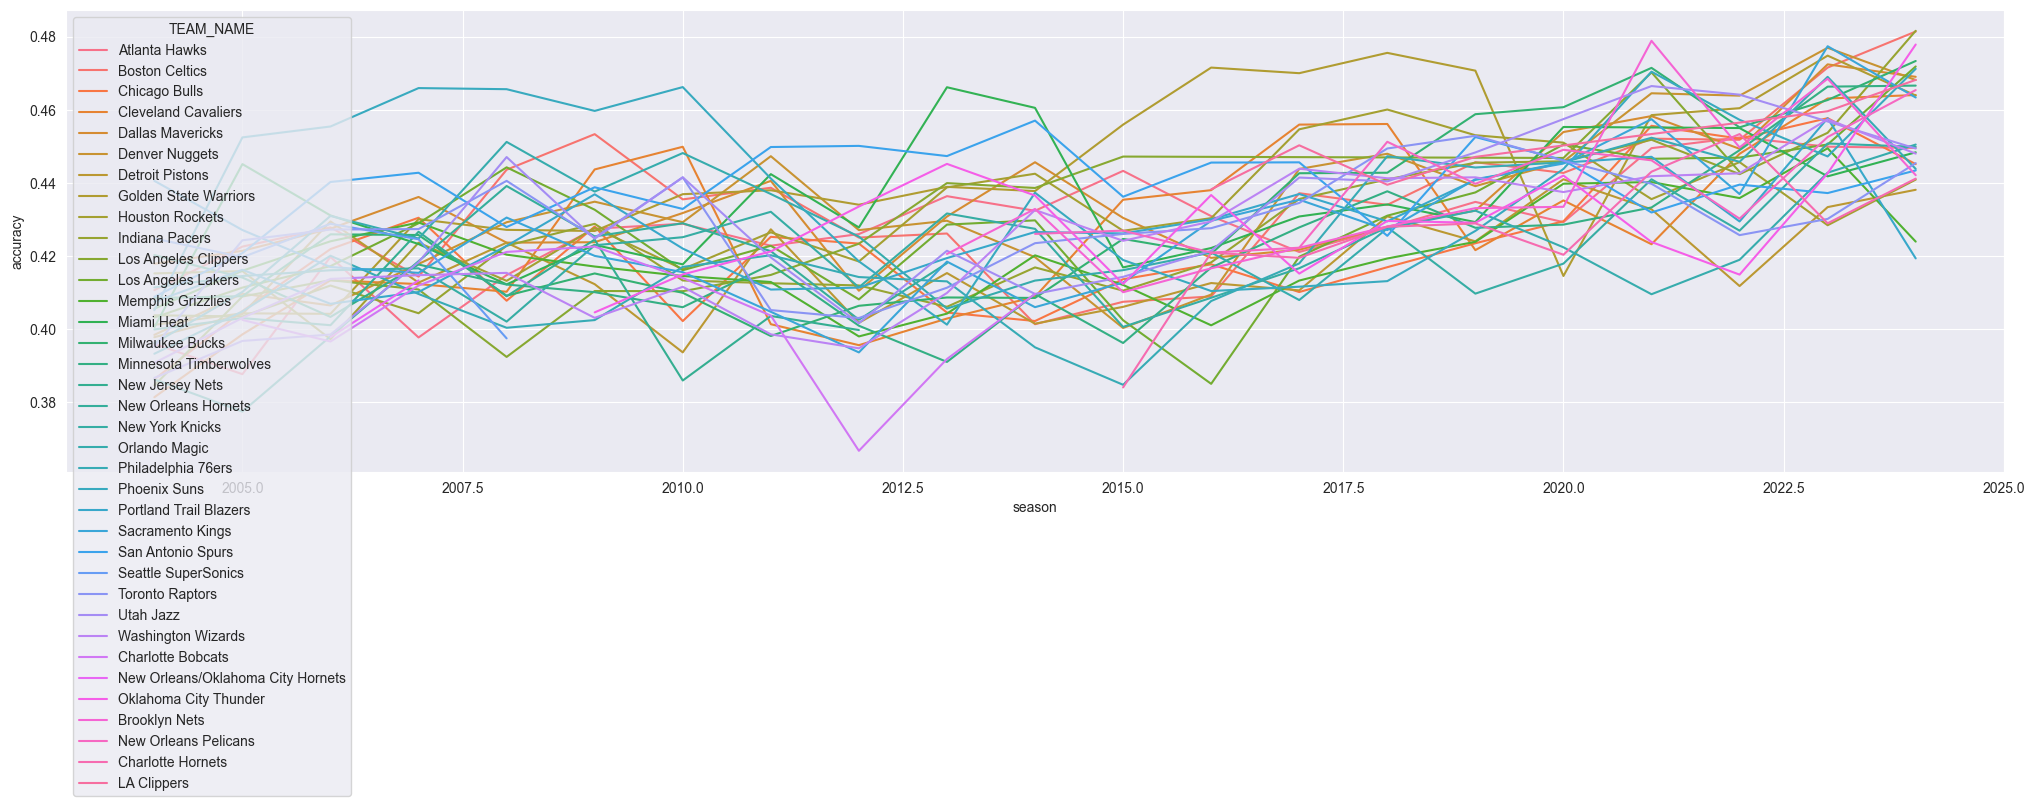

In [204]:
#TODO: Accuracy by Team for 2pt over time with a trendline league average
plt.figure(figsize=(25,6))
sns.lineplot(data=shot_type_df, x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False, errorbar=None)
#TODO: Accuracy by Team for 3pt over time with a trendline league average



# Predictive Models
- Shot success and accuracy prediction model
- Players synergy and selection model ? 

In [ ]:
conn.close()

,TEAM_ID,SEASON_YEAR,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CONFERENCE,TEAM_DIVISION,TEAM_CODE,TEAM_SLUG,W,L,PCT,CONF_RANK,DIV_RANK,MIN_YEAR,MAX_YEAR,TeamName
0,1610612737,2024-25,Atlanta,Hawks,ATL,East,Southeast,hawks,hawks,4,7,0.364,11,4,1949,2024,Atlanta Hawks
1,1610612738,2024-25,Boston,Celtics,BOS,East,Atlantic,celtics,celtics,8,2,0.800,2,1,1946,2024,Boston Celtics
2,1610612739,2024-25,Cleveland,Cavaliers,CLE,East,Central,cavaliers,cavaliers,11,0,1.000,1,1,1970,2024,Cleveland Cavaliers
3,1610612740,2024-25,New Orleans,Pelicans,NOP,West,Southwest,pelicans,pelicans,3,7,0.300,14,5,2002,2024,New Orleans Pelicans
4,1610612741,2024-25,Chicago,Bulls,CHI,East,Central,bulls,bulls,4,6,0.400,7,3,1966,2024,Chicago Bulls
5,1610612742,2024-25,Dallas,Mavericks,DAL,West,Southwest,mavericks,mavericks,5,4,0.556,10,3,1980,2024,Dallas Mavericks
6,1610612743,2024-25,Denver,Nuggets,DEN,West,Northwest,nuggets,nuggets,6,3,0.667,5,3,1976,2024,Denver Nuggets
7,1610612744,2024-25,Golden State,Warriors,GSW,West,Pacific,warriors,warriors,7,2,0.778,3,2,1946,2024,Golden State Warriors
8,1610612745,2024-25,Houston,Rockets,HOU,West,Southwest,rockets,rockets,5,4,0.556,9,2,1967,2024,Houston Rockets
9,1610612746,2024-25,LA,Clippers,LAC,West,Pacific,clippers,clippers,6,4,0.600,7,3,1970,2024,Los Angeles Clippers
